# In this file : 

We are trynig to find the known bad buz using the decline events found in the channels in order to then use them to understand the cause and how the youtuber recovred from it 

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import ldamodel
from tqdm import tqdm
from gensim import corpora
import copy
from src.utils.recovery_analysis_utils import str_to_list

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data : 

In [ ]:
# Load the data where rolling growth rate have been calculated
df_with_rgr = pd.read_csv('data/df_with_rgr_new.tsv', sep='\t')
df_with_rgr.set_index(['channel', 'week'], inplace=True)
df_with_rgr.head()

In [ ]:
# Load data where decline events are marked
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

In [86]:
# Load bad buzz data and retrieve the channels that have suffered of bb in the decline dataset
data = load_bb_timeseries_processed(verbose=True)
df_all_declines_bb = df_all_declines_original[df_all_declines_original['Channel'].isin(data.index.get_level_values('channel').unique())]

Loading data in chunks of 1000: 6it [00:00, 158.57it/s]                  

Loaded 5030 rows


In [91]:
nb_channels_rgr = df_with_rgr.index.get_level_values('channel').nunique()
nb_channels_declines = df_all_declines_original['Channel'].nunique()
nb_channels_bb = df_all_declines_bb['Channel'].nunique()

print(f'Number of channels in rolling growth rate df : {nb_channels_rgr}')
print(f'Number of channels in decline events df : {nb_channels_declines}')
print(f'Number of channels in bad buzz df : {nb_channels_bb}')

Number of channels in rolling growth rate df : 133516
Number of channels in decline events df : 65110
Number of channels in bad buzz df : 25


# Process data 

In [78]:
df_all_declines = df_all_declines_original.copy()

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

df_all_declines = df_all_declines.merge(df_channels, left_on='Channel', right_index=True)

decline_index_start = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
decline_index_end = list(zip(df_all_declines['Channel'], df_all_declines['End']))

# Add the channel's subs at the start of the decline
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index_start, 'subs'].values

# Add the channel's sub at the end of the decline
df_all_declines['Subs_end'] = df_data_processed.loc[decline_index_end, 'subs'].values

# Add the difference in subs at the start and end of the decline
df_all_declines['Subs_diff'] = df_all_declines['Subs_end'] - df_all_declines['Subs_start']

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index_start, 'activity'].values

# Add the activity at the end of the decline
df_all_declines['Activity_end'] = df_data_processed.loc[decline_index_end, 'activity'].values

# Add the difference in activity at the start and end of the decline
df_all_declines['Activity_diff'] = df_all_declines['Activity_end'] - df_all_declines['Activity_start']

In [92]:
df_all_declines.head()

,Channel,Duration,Start,End,category_cc,Subs_start,Subs_end,Subs_diff,Activity_start,Activity_end,Activity_diff
0,UCi8IX8CVCHRKiLV_eCWEKNA,20,117,137,People & Blogs,32974.875000,35399.250000,2424.375000,1,1,0
1,UCi8IX8CVCHRKiLV_eCWEKNA,28,190,218,People & Blogs,150182.875000,169922.963542,19740.088542,3,4,1
2,UCW4jUKddkdTJwl3EFlc8ZMQ,13,218,231,Film and Animation,12939.125000,13503.017857,563.892857,0,0,0
3,UC_hZX0wqyjq3CabYF25ol8Q,18,224,242,Gaming,16797.444444,17649.300000,851.855556,4,2,-2
4,UC-TDzpXxJndgBvyX4dZXVzA,29,172,201,Music,22794.200000,24041.734375,1247.534375,0,14,14


In [98]:
df_all_declines_bb = df_all_declines[df_all_declines['Channel'].isin(data.index.get_level_values('channel').unique())]

In [95]:
df_pewDiePie = df_with_rgr[df_with_rgr.index.get_level_values('channel') == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']
df_pewDiePie_declines = df_all_declines[df_all_declines['Channel'] == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']
df_pewDiePie_bb = data.loc['UC-lHJZR3Gqxm24_Vd_AJ5Yw']

# Let's analyze the Duration, the Subs_diff and the Activity_diff during a decline and a bad buzz 

In [63]:
df_all_declines[['Duration', 'Subs_diff', 'Activity_diff']].describe()

,Duration,Subs_diff,Activity_diff
count,121998.000000,1.219980e+05,121998.000000
mean,17.353145,5.818135e+03,-0.045419
std,7.613838,5.128609e+04,15.129637
min,8.000000,-2.054109e+06,-1362.000000
25%,11.000000,7.494931e+01,-1.000000
50%,16.000000,5.879949e+02,0.000000
75%,21.000000,2.426747e+03,1.000000
max,104.000000,6.000715e+06,2471.000000


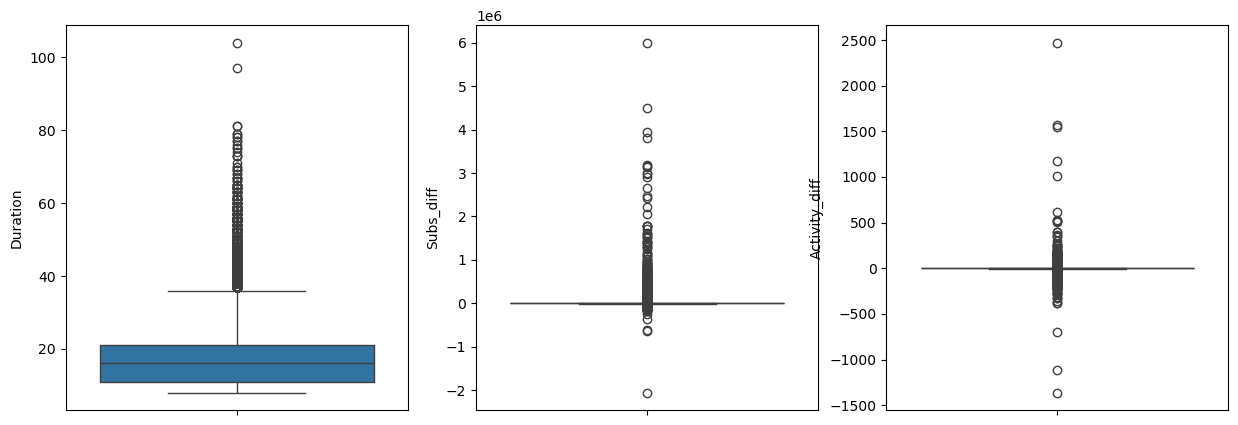

In [96]:
# plot the boxplot of the duration, the subs_diff and teh activity_diff  of the decline events
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='Duration', data=df_all_declines, ax=ax[0])
sns.boxplot(y='Subs_diff', data=df_all_declines, ax=ax[1])
sns.boxplot(y='Activity_diff', data=df_all_declines, ax=ax[2])
plt.show()

In [ ]:
df_all_declines_bb[['Duration', 'Subs_diff', 'Activity_diff']].describe()

,Duration,Subs_diff,Activity_diff
count,49.000000,4.900000e+01,49.000000
mean,14.510204,2.643314e+05,-0.163265
std,4.449356,9.682377e+05,3.023153
min,8.000000,-6.338607e+05,-6.000000
25%,11.000000,-4.460663e+03,-2.000000
50%,14.000000,3.527572e+04,0.000000
75%,18.000000,1.264382e+05,2.000000
max,25.000000,6.000715e+06,7.000000


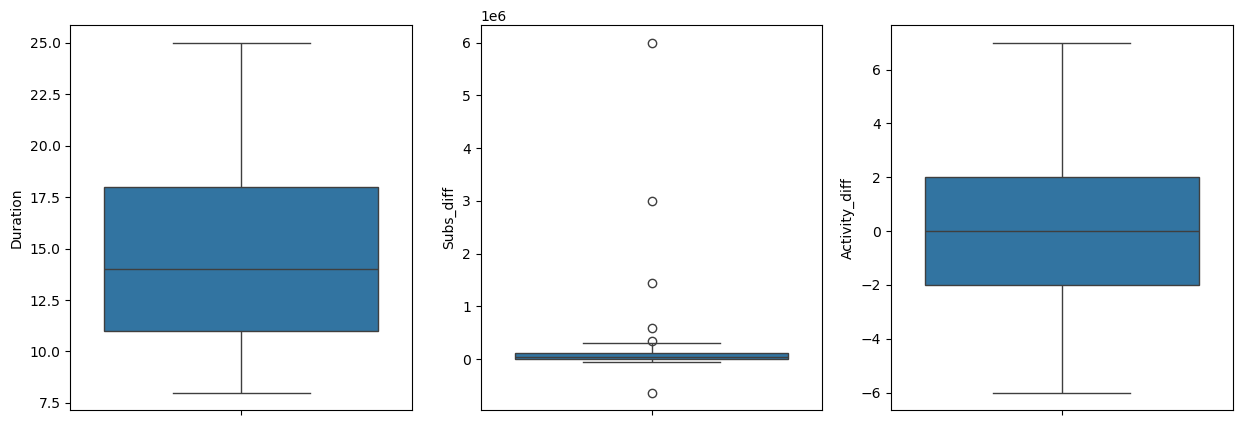

In [101]:
# plot the boxplot of the duration, the subs_diff and teh activity_diff  of the decline events
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='Duration', data=df_all_declines_bb, ax=ax[0])
sns.boxplot(y='Subs_diff', data=df_all_declines_bb, ax=ax[1])
sns.boxplot(y='Activity_diff', data=df_all_declines_bb, ax=ax[2])
plt.show()

We observe that the subs_diff has a lot of outliers both in the decline df and in the bb df which means it will be difficult to manipuate this variable. 

On the contrary the activity diff doesn't have a lot of outliers in the bb df as opposed to the decline df. Meaning that we could set a threshold on the activity_diff. 

Then regarding the duration in bb df there aren't any outliers whereas in decline df there are quite a lot, here as well in order to remove the outliers a further analysis is needed. 

# Setting threshold on activity_diff

In [108]:
ACTIVITY_THRESHOLD = 5
df_all_declines_filtered = df_all_declines[(-ACTIVITY_THRESHOLD < df_all_declines['Activity_diff']) & (df_all_declines['Activity_diff'] < ACTIVITY_THRESHOLD)]
nb_channels_declines_filtered = df_all_declines_filtered['Channel'].nunique()

print(f'Number of channels in decline events df before filtering : {nb_channels_declines}')
print(f'Number of channels in decline events df after filtering : {nb_channels_declines_filtered}')

Number of channels in decline events df before filtering : 65110
Number of channels in decline events df after filtering : 59514


In [109]:
df_all_declines_filtered[['Duration', 'Subs_diff', 'Activity_diff']].describe()

,Duration,Subs_diff,Activity_diff
count,105905.000000,1.059050e+05,105905.000000
mean,17.259874,5.590722e+03,0.009244
std,7.573952,5.196109e+04,1.484643
min,8.000000,-2.054109e+06,-4.000000
25%,11.000000,6.425000e+01,-1.000000
50%,16.000000,5.440425e+02,0.000000
75%,21.000000,2.288529e+03,1.000000
max,104.000000,6.000715e+06,4.000000


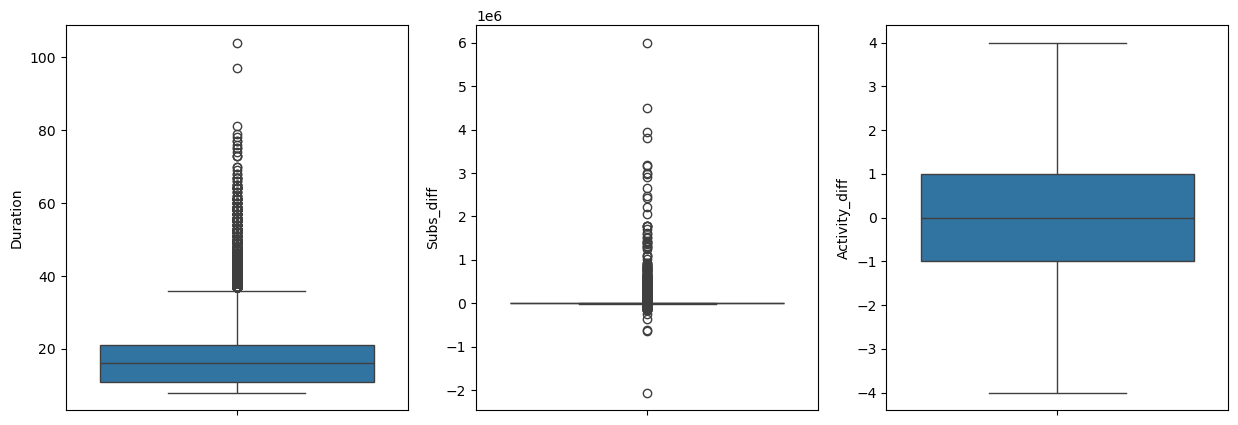

In [110]:
# plot the boxplot of the duration, the subs_diff and teh activity_diff  of the decline events
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='Duration', data=df_all_declines_filtered, ax=ax[0])
sns.boxplot(y='Subs_diff', data=df_all_declines_filtered, ax=ax[1])
sns.boxplot(y='Activity_diff', data=df_all_declines_filtered, ax=ax[2])
plt.show()

# Subscribers analysis 

We can notice two different phenomenas when we talk about declines and observe the number of subs.

During a decline some channels can :
    - loose some subs => negative subs_diff 
    - increase of subs can be slower 
    
It would be interesting to identify how many channel lost some subs.

In [111]:
df_all_declines[['Subs_diff']].describe()

,Subs_diff
count,1.219980e+05
mean,5.818135e+03
std,5.128609e+04
min,-2.054109e+06
25%,7.494931e+01
50%,5.879949e+02
75%,2.426747e+03
max,6.000715e+06


In [112]:
df_all_declines_filtered[['Subs_diff']].describe()

,Subs_diff
count,1.059050e+05
mean,5.590722e+03
std,5.196109e+04
min,-2.054109e+06
25%,6.425000e+01
50%,5.440425e+02
75%,2.288529e+03
max,6.000715e+06


In [113]:
df_all_declines_bb[['Subs_diff']].describe()

,Subs_diff
count,4.900000e+01
mean,2.643314e+05
std,9.682377e+05
min,-6.338607e+05
25%,-4.460663e+03
50%,3.527572e+04
75%,1.264382e+05
max,6.000715e+06


In [114]:
df_all_declines_neg_sub_loss = df_all_declines[df_all_declines['Subs_diff'] < 0]
nb_channels_neg_sub_loss = df_all_declines_neg_sub_loss['Channel'].nunique()
print(f'Number of channels with negative sub loss : {nb_channels_neg_sub_loss}')

Number of channels with negative sub loss : 14577


# Load the data 

In [115]:
# Load the data with rolling growth rate
df_with_rgr_new = pd.read_csv('data/df_with_rgr_new.tsv', sep='\t')
df_with_rgr_new.set_index(['channel', 'week'], inplace=True)

In [116]:
# Detection of period where growth_rate < rolling_growth_rate
df_with_rgr_new['decline_event_detected'] = df_with_rgr_new['growth_diff'] < 0
df_with_rgr_new.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0   
                         83           2      5336.0       204.0   
                         84           2      5727.0       232.0   
                         85           2     19214.0       318.0   
                         86           2      6949.0       234.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82              1.0                  NaN   
                         83              1.0                  NaN   
                         84              1.0                  NaN   
                         85              7.0                  NaN   
                         86              1.0                  NaN   

                               growth_diff  decline_event_detected  
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82            NaN                   False  
                         83            NaN                   False  
                         84            NaN                   False  
                         85            NaN                   False  
                         86            NaN                   False

In [117]:
df_with_rgr_grouped = df_with_rgr_new.reset_index().groupby('channel')

print(f'Number of channels : {len(df_with_rgr_grouped.groups.keys())}')

Number of channels : 133516


In [141]:
# Sample DataFrame (replace this with your actual DataFrame)
df_with_rgr_grouped = pd.DataFrame({
    'channel': ['UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'other_channel', 'other_channel'],
    'week': [1, 2, 1, 2],
    'decline_event_detected': [False, True, False, True]
}).groupby('channel')

# Initialize the new columns
df_with_rgr_grouped['start_week'] = None
df_with_rgr_grouped['end_week'] = None

# For loop to detect the starting and ending week of the decline event
for channel in tqdm(df_with_rgr_grouped.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped.get_group(channel).copy()

    # Identify indices where decline has started and ended
    for i in range(1, len(channel_data)):
        if channel_data['decline_event_detected'].iloc[i] and not channel_data['decline_event_detected'].iloc[i-1]:
            # Add the starting week of the decline event
            channel_data.at[channel_data.index[i], 'start_week'] = channel_data['week'].iloc[i]
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                print(f'Channel {channel} has a decline event that starts in week {channel_data["week"].iloc[i]}.')
        if not channel_data['decline_event_detected'].iloc[i] and channel_data['decline_event_detected'].iloc[i-1]:
            # Add the ending week of the decline event
            channel_data.at[channel_data.index[i], 'end_week'] = channel_data['week'].iloc[i]
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                print(f'Channel {channel} has a decline event that ends in week {channel_data["week"].iloc[i]}.')

    # Update the original DataFrame with the new columns
    df_with_rgr_grouped.update(channel_data)

# Reset the index to view the updated DataFrame
df_with_rgr_updated = df_with_rgr_grouped.reset_index()
print(df_with_rgr_updated)

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [118]:
# Create a map that contains for each entry: the id of the channel, and the starting week and end week of each decline event
decline_events = {}

# For loop to detect the starting and ending week of the decline event
for channel in tqdm(df_with_rgr_grouped.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped.get_group(channel)

    # Identify indices where decline has started and ended
    for i in range(1, len(channel_data)):
        if channel_data['decline_event_detected'].iloc[i] and not channel_data['decline_event_detected'].iloc[i-1]:
            # Add the starting week of the decline event
            if channel not in decline_events:
                decline_events[channel] = []
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                print(f'Channel {channel} has a decline event that starts.')
            decline_events[channel].append((channel_data['week'].iloc[i], None))
        if ((not channel_data['decline_event_detected'].iloc[i]) and channel_data['decline_event_detected'].iloc[i-1]):
            # Add the ending week of the decline event
            decline_events[channel][-1] = (decline_events[channel][-1][0], channel_data['week'].iloc[i])
            if channel == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw':
                    print(f'Channel {channel} has a decline event that ends.')


Processing channels:   1%|▏         | 1735/133516 [00:03<03:31, 624.03it/s]

Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that ends.
Channel UC-lHJZR3Gqxm24_Vd_AJ5Yw has a decline event that starts.
Channel UC-lHJZR3Gqxm24_

Processing channels: 100%|██████████| 133516/133516 [03:48<00:00, 585.18it/s]


In [119]:
print(f'Total number of decline events found: {sum([len(v) for v in decline_events.values()])}')

Total number of decline events found: 1491324


In [120]:
# Remove only the events (tuples) with None as the second element
decline_events_no_None = {k: [x for x in v if x[1] is not None] for k, v in decline_events.items()}

In [123]:
# Add the duration of the decline event for each decline event for each channel (created from a deep copy of the original decline events)
decline_events_with_duration = copy.deepcopy(decline_events_no_None)

for channel in decline_events_with_duration:
    for i in range(len(decline_events_with_duration[channel])):
        decline_events_with_duration[channel][i] = ((decline_events_with_duration[channel][i][0], decline_events_with_duration[channel][i][1]), decline_events_with_duration[channel][i][1] - decline_events_with_duration[channel][i][0])

In [124]:
# Filter out the decline events that are shorter than the minimum duration

DECLINE_MIN_DURATION = 8 # Set the minimum duration of a detected decline event to be considered as an effective decline event
de_filtered_on_duration = {k: [x for x in v if x[1] >= DECLINE_MIN_DURATION] for k, v in decline_events_with_duration.items()}

In [125]:
print(f'There are {sum([len(v) for v in de_filtered_on_duration.values()])} decline events with duration of at least {DECLINE_MIN_DURATION} weeks.')

There are 379697 decline events with duration of at least 8 weeks.


In [139]:
de_filtered_on_duration

{'UC--24Q3_ZQeFmgJE-Um5QZQ': [((114, 126), 12),
  ((148, 166), 18),
  ((184, 197), 13),
  ((209, 221), 12)],
 'UC--2EbuIuBOGgGqPiJxi3rg': [((147, 162), 15),
  ((173, 182), 9),
  ((185, 198), 13),
  ((219, 227), 8),
  ((230, 240), 10)],
 'UC--3c8RqSfAqYBdDjIG3UNA': [],
 'UC--3ozenTzry39-xMqAPQlw': [((121, 146), 25),
  ((158, 166), 8),
  ((169, 186), 17),
  ((210, 228), 18)],
 'UC--6E6EpybocdaNlPhvK_9A': [((130, 146), 16),
  ((149, 159), 10),
  ((206, 216), 10),
  ((221, 235), 14)],
 'UC--70ql_IxJmhmqXqrkJrWQ': [((112, 121), 9),
  ((129, 144), 15),
  ((147, 156), 9),
  ((189, 198), 9),
  ((218, 227), 9)],
 'UC--7oyGW0N7fMf164-ZXljQ': [((221, 233), 12)],
 'UC--94OGFAzYDOJb0eXgMjew': [((163, 171), 8), ((208, 222), 14)],
 'UC--BMyA2X4a9PGAo3lTuopg': [((112, 122), 10),
  ((138, 146), 8),
  ((159, 180), 21),
  ((182, 198), 16),
  ((212, 228), 16),
  ((230, 239), 9)],
 'UC--EwQJeJ6SKlJdswehQH4g': [((113, 132), 19),
  ((141, 158), 17),
  ((199, 207), 8),
  ((209, 227), 18),
  ((233, 243), 10)],

In [128]:
# Compute the growth diff percentage
df_with_rgr_final = df_with_rgr_new
df_with_rgr_final['growth_diff_percentage'] = (df_with_rgr_final['growth_diff'] / df_with_rgr_final['rolling_growth_rate']) * 100
df_with_rgr_final.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  \
channel                  week                                     
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0   
                         83           2      5336.0       204.0   
                         84           2      5727.0       232.0   
                         85           2     19214.0       318.0   
                         86           2      6949.0       234.0   

                               dislike_count  rolling_growth_rate  \
channel                  week                                       
UC--24Q3_ZQeFmgJE-Um5QZQ 82              1.0                  NaN   
                         83              1.0                  NaN   
                         84              1.0                  NaN   
                         85              7.0                  NaN   
                         86              1.0                  NaN   

                               growth_diff  decline_event_detected  \
channel                  week                                        
UC--24Q3_ZQeFmgJE-Um5QZQ 82            NaN                   False   
                         83            NaN                   False   
                         84            NaN                   False   
                         85            NaN                   False   
                         86            NaN                   False   

                               growth_diff_percentage  
channel                  week                          
UC--24Q3_ZQeFmgJE-Um5QZQ 82                       NaN  
                         83                       NaN  
                         84                       NaN  
                         85                       NaN  
                         86                       NaN

In [137]:
df_with_rgr_grouped_final = df_with_rgr_final.reset_index().groupby('channel')

In [138]:
# From the decline events filtered out because of a too short duration, we check if the event should still be included in the list of decline events, 
# because it is too intense (i.e. the minimum growth difference is below a certain threshold)

DECLINE_MIN_GROWTH_DIFF_PERCENTAGE = - 80 # Set the minimum magnitude of the growth difference to be considered as an effective decline event

# For each channel, for each event:
# We keep the event only if the miimum growth difference during the period starting from the first week of the event to the last week of the event is less than the threshold
de_filtered_on_growth_diff = {}

for channel in tqdm(df_with_rgr_grouped_final.groups.keys(), desc="Processing channels"):
    channel_data = df_with_rgr_grouped_final.get_group(channel)
    for event in decline_events_with_duration.get(channel, []):
        start_week = event[0][0]
        end_week = event[0][1]
        min_growth_diff = channel_data.loc[(channel_data['week'] >= start_week) & (channel_data['week'] <= end_week)]['growth_diff_percentage'].min()
        if min_growth_diff < DECLINE_MIN_GROWTH_DIFF_PERCENTAGE:
            if channel not in de_filtered_on_growth_diff:
                de_filtered_on_growth_diff[channel] = []
            de_filtered_on_growth_diff[channel].append(event)

Processing channels: 100%|██████████| 133516/133516 [04:25<00:00, 502.53it/s]


In [129]:
# Filter out the channels that doesn't have more than 1 million subs
df_with_rgr_subs_filtered = df_with_rgr_final[df_with_rgr_final['subs'] > 1e6]

In [130]:
nb_channels = df_with_rgr_final.index.get_level_values('channel').nunique()
nb_channels_subs_filtered = df_with_rgr_subs_filtered.index.get_level_values('channel').nunique()

print(f'Number of channels in the original df : {nb_channels}')
print(f'Number of channels in the filtered df : {nb_channels_subs_filtered}')

Number of channels in the original df : 133516
Number of channels in the filtered df : 6158


In [135]:
# Filter out the channels that have a growth_diff_percentage of more than 100%
df_with_rgr_subs_filtered = df_with_rgr_subs_filtered[df_with_rgr_subs_filtered['growth_diff_percentage'] < -150]



In [136]:
nb_channels_subs_filtered = df_with_rgr_subs_filtered.index.get_level_values('channel').nunique()
print(f'Number of channels in the filtered df : {nb_channels_subs_filtered}')

Number of channels in the filtered df : 1769
